In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import h5py
import cv2
import random
import glob
import math
import pickle

from os import path
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import models
from tensorflow.image import ResizeMethod
from random import shuffle
from tensorflow.keras.utils import Sequence
from keras import backend as K
from utils import *
from model import *

AUTOTUNE = tf.data.AUTOTUNE
TRAIN_DIR = "./Data/"
bs = 32
scale = 4 # 3 or 4
patch_size = 96
img_size = int(patch_size * scale)

In [2]:
# if no imgaes are generated the genaret some
generate_images()

Generated directory exists with files. Not generating data.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
IMAGES = sorted(glob.glob(TRAIN_DIR + '**/*.png', recursive=True))
TRAIN_IMAGES, VAL_IMAGES = split_train_test(IMAGES)

print(f"Total Images: {len(IMAGES)} Train: {len(TRAIN_IMAGES)} Validation: {len(VAL_IMAGES)}")
sr_trn_gen = ImageLoader(TRAIN_IMAGES, patch_size, scale, batchSize = bs)
sr_val_gen = ImageLoader(VAL_IMAGES, patch_size, scale, batchSize = bs)

Total Images: 57 Train: 45 Validation: 12


In [5]:
_model = make_model(num_filters=64, num_of_residual_blocks=6, scale_factor=scale)
_model.summary()

Model: "lightweight_sr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['rescaling[0][0]']              


2022-09-01 18:42:36.847873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 18:42:37.244389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9443 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:26:00.0, compute capability: 6.1


                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, None, None,   36928       ['conv2d_1[0][0]']               
                                64)                                                               
                                                                                                  
 add (Add)                      (None, None, None,   0           ['conv2d[0][0]',                 
                                64)                               'conv2d_2[0][0]']               
          

In [6]:
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

checkpointer = ModelCheckpoint(filepath = 'checkpoints/model/sr_mymodel_loss_x{}.h5'.format(scale), verbose=1, 
                               save_best_only=True, save_weights_only=True,
                               monitor = 'loss')
callbacks= [checkpointer]

# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
_model.compile(optimizer=optim_edsr, loss="mae", metrics=[ssim, PSNR, "acc"])
# Training for more epochs will improve results
#model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)
_history = _model.fit(sr_trn_gen, validation_data=sr_val_gen, epochs=500, steps_per_epoch=16, callbacks=callbacks, workers=8, use_multiprocessing=True)

Epoch 1/500


2022-09-01 18:42:39.877112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


16/16 [==============================] - ETA: 0s - loss: 110.5055 - ssim: 0.0198 - PSNR: 5.4569 - acc: 0.3434
Epoch 1: loss improved from inf to 110.50546, saving model to checkpoints/model/sr_mymodel_loss_x4.h5
16/16 [==============================] - 10s 429ms/step - loss: 110.5055 - ssim: 0.0198 - PSNR: 5.4569 - acc: 0.3434 - val_loss: 93.3243 - val_ssim: 0.0331 - val_PSNR: 5.8455 - val_acc: 0.4968
Epoch 2/500
16/16 [==============================] - ETA: 0s - loss: 89.8499 - ssim: 0.0752 - PSNR: 5.7331 - acc: 0.5616
Epoch 2: loss improved from 110.50546 to 89.84992, saving model to checkpoints/model/sr_mymodel_loss_x4.h5
16/16 [==============================] - 7s 444ms/step - loss: 89.8499 - ssim: 0.0752 - PSNR: 5.7331 - acc: 0.5616 - val_loss: 79.9304 - val_ssim: 0.0829 - val_PSNR: 6.0135 - val_acc: 0.5500
Epoch 3/500
16/16 [==============================] - ETA: 0s - loss: 78.8148 - ssim: 0.1142 - PSNR: 6.1544 - acc: 0.6061
Epoch 3: loss improved from 89.84992 to 78.81480, savin

In [7]:
print(_history.history.keys())

# save training history as a pickle
with open('checkpoints/history/train_history_dict_x{}'.format(scale), 'wb') as file_pi:
      pickle.dump(_history.history, file_pi)

dict_keys(['loss', 'ssim', 'PSNR', 'acc', 'val_loss', 'val_ssim', 'val_PSNR', 'val_acc'])


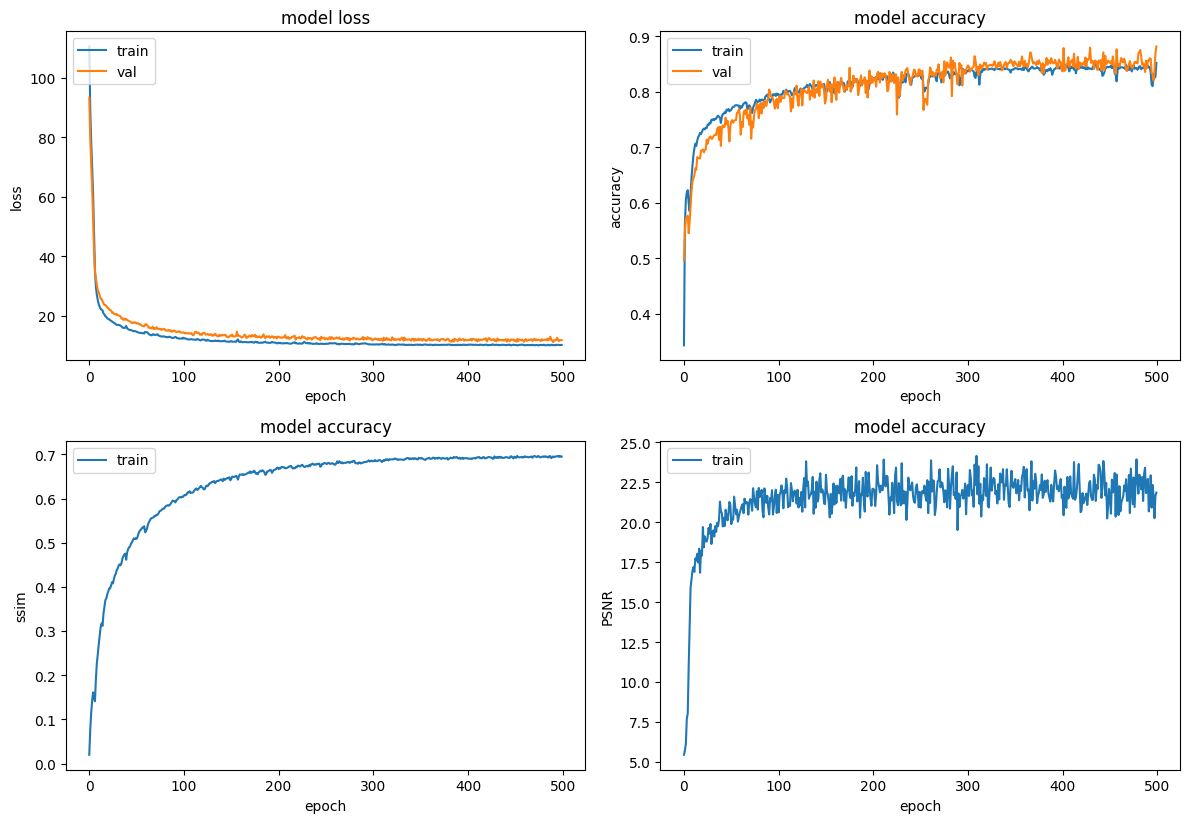

In [8]:
plot_metrics(_history)

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

def plot_zoomed_results(img_bi, img_pred, img_gt, prefix, title):
    """Plot the result with zoom-in area."""
    #img_array = img_to_array(img)
    img_bi = img_to_array(img_bi)
    img_pred = img_to_array(img_pred)
    img_gt = img_to_array(img_gt)
    img_bi = img_bi.astype("float32") / 255.0
    img_pred = img_pred.astype("float32") / 255.0
    img_gt = img_gt.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(1,3,1)

    im = ax.imshow(img_bi[::-1], origin="lower")

    plt.title(f"{title} - bicubic")
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_bi[::-1], origin="lower")

    img_width= img_bi.shape[0]
    img_height= img_bi.shape[1]
    _ins_area_width = img_width//4
    
    # Specify the limits.
    x1, x2, y1, y2 = img_width//2 - _ins_area_width//2, img_width//2 + _ins_area_width//2, img_height//2 - _ins_area_width//2, img_height//2 + _ins_area_width//2
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")

    ax = plt.subplot(1,3,2)

    im = ax.imshow(img_pred[::-1], origin="lower")

    plt.title(f"{title} - predicted")
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_pred[::-1], origin="lower")

    img_width= img_pred.shape[0]
    img_height= img_pred.shape[1]
    _ins_area_width = img_width//4
    
    # Specify the limits.
    x1, x2, y1, y2 = img_width//2 - _ins_area_width//2, img_width//2 + _ins_area_width//2, img_height//2 - _ins_area_width//2, img_height//2 + _ins_area_width//2
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")

    ax = plt.subplot(1,3,3)

    im = ax.imshow(img_gt[::-1], origin="lower")

    plt.title(f"{title} - ground truth")
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_gt[::-1], origin="lower")

    img_width= img_gt.shape[0]
    img_height= img_gt.shape[1]
    _ins_area_width = img_width//4

    # Specify the limits.
    x1, x2, y1, y2 = img_width//2 - _ins_area_width//2, img_width//2 + _ins_area_width//2, img_height//2 - _ins_area_width//2, img_height//2 + _ins_area_width//2
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig("inference/" + str(prefix) + title + "_gt.png")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


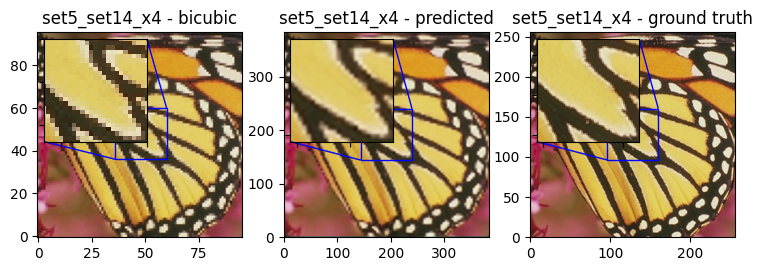

In [10]:
_test_img = Image.open(os.path.join(TRAIN_DIR, "Set5/Set5/butterfly.png"))
_test_img_llr = tf.image.resize(img_to_array(_test_img), [96,96], method= ResizeMethod.BICUBIC)
_test_img_pred=_model.predict_step(_test_img_llr)

plot_zoomed_results(_test_img_llr, _test_img_pred, img_to_array(_test_img), "img_", f"set5_set14_x{scale}")

In [11]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")


In [12]:
_ds = image_dataset_from_directory(
    root_dir,
    batch_size=1,
    image_size=(384, 384),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


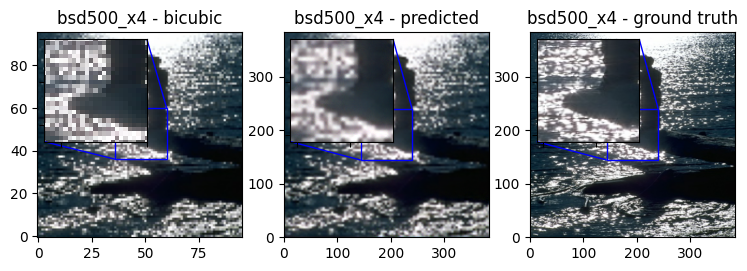

In [13]:
_take = _ds.take(1)
for batch in _take:
    for img in batch:
        _test_img = img
        _test_img_llr = tf.image.resize(img_to_array(_test_img), [96,96], method= ResizeMethod.BICUBIC)
        _test_img_pred=_model.predict_step(_test_img_llr)

        plot_zoomed_results(_test_img_llr, _test_img_pred, img_to_array(_test_img), "img_", f"bsd500_x{scale}")